In [ ]:
!pip install jax jaxlib
!pip install --quiet --upgrade scipy
!pip install --quiet jax jaxlib optax

In [ ]:
import jax
from jax.scipy.stats import norm
import jax.numpy as jnp
from scipy.stats import norm
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar, brentq, minimize
from scipy.special import gamma
from numpy.polynomial.legendre import leggauss
import warnings
warnings.filterwarnings('ignore')
from math import log
from numpy.random import default_rng, SeedSequence
from scipy.stats import kstwobign, cramervonmises, uniform
from joblib import Parallel, delayed
from itertools import zip_longest
from collections import OrderedDict
from scipy.stats import uniform, cramervonmises, kstwobign
from joblib import Parallel, delayed
from itertools import zip_longest
import matplotlib.patches as mpatches


# ==============================================================
# Real Data Analysis
# ==============================================================


In [ ]:
# ==============================================================
# DESIGN B: Real Data Analysis - Norwegian Fire Insurance
# Different J (J₁ ≠ J₂), Same h = log(x)
# ==============================================================

# ==============================================================
# 1) LOAD DATA
# ==============================================================

path = "/content/sample_data/norwegianfire_raw.csv"
df = pd.read_csv(path)
df["year_full"] = 1900 + df["year"].astype(int)

# -------- Choose the cap in NOK -----------------
MONSTER_NOK = 2_000_000_000  # 2 billion NOK
MONSTER_kNOK = MONSTER_NOK / 1_000.0

# 2) Strict threshold: keep claims EXCEEDING 500 kNOK
theta_kNOK = 500.0
df_work = df.loc[df["size"] > theta_kNOK].copy()
n_total = len(df)
n_work  = len(df_work)

# 3) Helper for "nearest" empirical quantile
def q_nearest(x: np.ndarray, p: float) -> float:
    x = np.asarray(x, float)
    x = x[~np.isnan(x)]
    if x.size == 0:
        return np.nan
    s = pd.Series(x)
    try:
        return float(s.quantile(p, method="nearest"))
    except TypeError:
        try:
            return float(s.quantile(p, interpolation="nearest"))
        except TypeError:
            try:
                return float(np.quantile(x, p, method="nearest"))
            except TypeError:
                return float(np.percentile(x, 100*p, interpolation="nearest"))

# 4) Headline stats
s = df_work["size"].astype(float)
n = s.size
m1 = s.mean()
q1 = q_nearest(s.values, 0.25)
q3 = q_nearest(s.values, 0.75)
m2 = np.mean((s - m1)**2)
m3 = np.mean((s - m1)**3)
g1 = m3 / (m2**1.5) if m2 > 0 else np.nan
skew_unbiased = (np.sqrt(n*(n-1))/(n-2))*g1 if n > 2 else np.nan

print("=== Norwegian fire insurance (kNOK), strict > 500 ===")
print(f"n_total: {n_total}")
print(f"n_after_theta (x>500): {n_work}")
print(f"year_min_max: ({int(df['year_full'].min())}, {int(df['year_full'].max())})")
print(f"min_kNOK: {s.min():,.0f}")
print(f"max_kNOK: {s.max():,.0f}")
print(f"mean_kNOK: {m1:,.3f}")
print(f"q1_kNOK: {q1:,.0f}")
print(f"q3_kNOK: {q3:,.0f}")
print(f"skewness: {skew_unbiased:.2f}")


=== Norwegian fire insurance (kNOK), strict > 500 ===
n_total: 9181
n_after_theta (x>500): 9020
year_min_max: (1972, 1992)
min_kNOK: 501
max_kNOK: 465,365
mean_kNOK: 2,247.860
q1_kNOK: 711
q3_kNOK: 1,817
skewness: 30.61


In [ ]:

 # ---------- Build the four arrays ----------
# 1) Original data
x_original = np.asarray(df_work["size"].values, dtype=float)
x_original = np.sort(x_original)

# 2) Modified original
x_mod_original = x_original.copy()
imax = np.argmax(x_mod_original)
x_mod_original[imax] = MONSTER_kNOK
x_mod_original = np.sort(x_mod_original)

# 3) Sampled: n=50
rng = np.random.default_rng(123)
idx50 = rng.choice(x_original.shape[0], size=50, replace=False)
x_sampled = np.sort(x_original[idx50])

# 4) Modified sampled
x_mod_sampled = x_sampled.copy()
jmax = np.argmax(x_mod_sampled)
x_mod_sampled[jmax] = MONSTER_kNOK
x_mod_sampled = np.sort(x_mod_sampled)

# 5) Wire up θ
θ = theta_kNOK

print(f"\nCounts: {len(x_original)}, {len(x_mod_original)}, {len(x_sampled)}, {len(x_mod_sampled)}")
print(f"Original max -> Modified original max: {np.max(x_original):,.0f} -> {np.max(x_mod_original):,.0f}")
print(f"Sampled max  -> Modified sampled max : {np.max(x_sampled):,.0f}  -> {np.max(x_mod_sampled):,.0f}")
print(f"θ (fixed): {θ:,.0f} kNOK")
print(f"Monster (cap): {MONSTER_kNOK:,.0f} kNOK  = {int(MONSTER_NOK):,} NOK")



Counts: 9020, 9020, 50, 50
Original max -> Modified original max: 465,365 -> 2,000,000
Sampled max  -> Modified sampled max : 4,607  -> 2,000,000
θ (fixed): 500 kNOK
Monster (cap): 2,000,000 kNOK  = 2,000,000,000 NOK


In [ ]:


# ---- optional: keep BLAS threads = 1 per worker to avoid oversubscription
try:
    from threadpoolctl import threadpool_limits
    _HAS_TPCTL = True
except Exception:
    _HAS_TPCTL = False

# ---------------- Performance knobs ----------------
N_JOBS       = -1       # use all cores
BACKEND      = "loky"   # processes for CPU-bound work
BLAS_THREADS = 1        # 1 BLAS thread per worker

# Numerical effort: high for observed fit, lighter for MC refits
NQUAD_OBS = 800
NQUAD_MC  = 200
GRID_OBS  = 401
GRID_MC   = 201
MC_BATCH  = 200         # chunk MC jobs to lower overhead

# ---- Monte-Carlo reps
# Use big B for full-sample fixed-parameter MC
MC_B_ORIG      = 10000
MC_B_MOD_ORIG  = 10000
# Moderate B for n=50 refitting MC
MC_B_SAMP      = 2000
MC_B_MOD_SAMP  = 2000

ln2 = np.log(2.0)


# ==============================================================
# 2) CORE ETLL FUNCTIONS
# ==============================================================

def etll_cdf(x, alpha, beta, theta):
    x = np.asarray(x, float)
    u = np.zeros_like(x, dtype=float)
    m = x > theta
    if not np.any(m):
        return u
    t = (theta / x[m])**alpha
    if abs(beta) < 1e-8:
        u[m] = 1.0 - (np.log1p(t) / ln2)
    else:
        two_b = np.exp(beta * ln2)
        u[m] = (two_b - np.power(1.0 + t, beta)) / (two_b - 1.0)
    return np.clip(u, 0.0, 1.0)

def ks_statistic(x, cdf):
    x = np.sort(np.asarray(x, float)); n = x.size
    u = cdf(x); ecdf = (np.arange(1, n+1)) / n
    return float(np.max(np.abs(u - ecdf)))

def cvm_statistic(x, cdf):
    x = np.sort(np.asarray(x, float)); n = x.size
    u = cdf(x); i = np.arange(1, n+1)
    return float(np.sum((u - (2*i - 1)/(2*n))**2) + 1.0/(12*n))

def etll_sample(n, alpha, beta, theta, rng=None):
    rng = default_rng() if rng is None else rng
    u = rng.uniform(0.0, 1.0, int(n))
    if abs(beta) < 1e-8:
        t = np.expm1((1.0 - u) * ln2)
    else:
        two_b = np.exp(beta * ln2)
        base  = two_b - (two_b - 1.0) * u
        base  = np.maximum(base, 1e-300)
        t     = np.expm1(np.log(base)/beta)
    return theta * np.power(t, -1.0/alpha)

def etll_loglik_alpha_beta(x, alpha, beta, theta):
    if alpha <= 0 or abs(beta) > 12:
        return -np.inf
    xv = np.asarray(x, float); xv = xv[xv > theta]
    if xv.size == 0:
        return -np.inf
    n = xv.size
    two_b = np.exp(beta * ln2)
    denom = two_b - 1.0
    if abs(denom) < 1e-14:
        denom = beta * ln2 + 0.5*(beta**2)*(ln2**2)
    const = np.log(alpha) + np.log(abs(beta)) - np.log(abs(denom))
    ratio = (theta / xv)**alpha
    ll = n*const - np.sum(np.log(xv)) + np.sum(alpha*np.log(theta/xv)) + (beta-1.0)*np.sum(np.log1p(ratio))
    return float(ll)

def fit_mle_etll(x, theta):
    x = np.asarray(x, float); x = x[x > theta]
    if x.size < 5:
        return np.nan, np.nan
    lx = np.log(x); m2 = np.mean((lx - lx.mean())**2)
    a0 = max(0.1, 1.0/np.sqrt(max(m2, 1e-6))); b0 = 0.5
    def nll(p):
        a,b = p; v = etll_loglik_alpha_beta(x, a, b, theta)
        return -v if np.isfinite(v) else 1e20
    res = minimize(nll, x0=[a0, b0], bounds=[(1e-3, 40.0), (-12.0, 12.0)], method="L-BFGS-B")
    if res.success:
        return float(res.x[0]), float(res.x[1])
    res = minimize(nll, x0=[1.5, 0.2], bounds=[(1e-3, 40.0), (-12.0, 12.0)], method="L-BFGS-B")
    return (float(res.x[0]), float(res.x[1])) if res.success else (np.nan, np.nan)

# ==============================================================
# 3) DESIGN B L-ESTIMATOR
# ==============================================================

def _cw_tau_designB(beta, a1, b1, a2, b2, n_quad):
    """
    Compute c_{w,1}, c_{w,2}, and τ_w for Design B
    """
    nodes, w = np.polynomial.legendre.leggauss(n_quad)
    u = 0.5*(nodes + 1.0); w = 0.5*w

    J1 = a1*b1 * (u**(a1-1.0)) * ((1.0 - u**a1)**(b1-1.0))
    J2 = a2*b2 * (u**(a2-1.0)) * ((1.0 - u**a2)**(b2-1.0))

    if abs(beta) < 1e-10:
        t = np.expm1((1.0 - u) * ln2)
    else:
        two_b = np.exp(beta * ln2)
        base  = two_b - (two_b - 1.0) * u
        base  = np.maximum(base, 1e-300)
        t     = np.expm1(np.log(base)/beta)

    t   = np.maximum(t, 1e-300)
    ell = np.log(t)

    c1  = float(np.sum(w * J1 * ell))
    c2  = float(np.sum(w * J2 * ell))
    tau_w = c2 - c1

    return c1, c2, tau_w

def fit_L_etll_designB_stable(x, a1=1.0, b1=1.0, a2=1.0, b2=2.0, theta=500.0,
                               n_quad=NQUAD_OBS, root_grid=GRID_OBS):
    """
    Design B: Two different weights J₁(a1,b1) and J₂(a2,b2)
    """
    x = np.asarray(x, float); x = x[x > theta]
    n = x.size
    if n < 5:
        return np.nan, np.nan

    xs  = np.sort(x)
    i   = np.arange(1, n+1)
    uo  = i/(n+1.0)

    # Two different weights
    J1 = a1*b1 * (uo**(a1-1.0)) * ((1.0 - uo**a1)**(b1-1.0))
    J2 = a2*b2 * (uo**(a2-1.0)) * ((1.0 - uo**a2)**(b2-1.0))

    # Normalize separately (important for Design B)
    J1 = J1 / np.sum(J1)
    J2 = J2 / np.sum(J2)

    lx = np.log(xs)
    mu1 = float(np.sum(J1 * lx))
    mu2 = float(np.sum(J2 * lx))
    Delta_w = mu2 - mu1

    if abs(Delta_w) < 1e-12:
        return np.nan, np.nan

    # Solve Ψ(β) = c_{w,1}/τ_w + (log θ - μ₁)/Δ_w = 0
    def Psi(beta):
        c1, c2, tau_w = _cw_tau_designB(beta, a1, b1, a2, b2, n_quad=n_quad)
        if abs(tau_w) < 1e-14:
            return np.nan
        return c1/tau_w + (np.log(theta) - mu1) / Delta_w

    grid = np.linspace(-10.0, 10.0, int(root_grid))
    vals = np.array([Psi(bi) for bi in grid])
    sgn  = np.sign(vals)

    beta_hat = None
    for k in range(len(grid)-1):
        if np.isfinite(vals[k]) and np.isfinite(vals[k+1]) and sgn[k]*sgn[k+1] < 0:
            try:
                beta_hat = brentq(lambda z: Psi(z), grid[k], grid[k+1], xtol=1e-8, maxiter=400)
                break
            except:
                continue

    if beta_hat is None:
        obj = lambda b: (Psi(b) if np.isfinite(Psi(b)) else 1e6)**2
        res = minimize_scalar(obj, bounds=(-10.0, 10.0), method="bounded",
                              options={"xatol":1e-8, "maxiter":1000})
        beta_hat = float(res.x)

    c1, c2, tau_w_hat = _cw_tau_designB(beta_hat, a1, b1, a2, b2, n_quad=n_quad)

    # Design B: α̂ = -τ_w / Δ_w
    alpha_hat = -tau_w_hat / Delta_w

    if alpha_hat <= 0:
        return np.nan, np.nan

    return float(alpha_hat), float(beta_hat)

def make_safe_L_designB_factory(a1_req, b1_req, a2_req, b2_req, fallbacks=None,
                                n_quad=NQUAD_OBS, root_grid=GRID_OBS):
    """
    Factory for Design B with fallbacks
    """
    if fallbacks is None:
        # Fallback to known good pairs
        fallbacks = [
            ((1.0, 1.0), (1.0, 2.0)),   # Optimal
            ((1.0, 1.0), (2.0, 1.0)),   # Optimal symmetric
            ((1.0, 1.0), (0.8, 1.0)),   # Moderate
        ]

    def fit_fun(z, _nq=n_quad, _rg=root_grid):
        ah, bh = fit_L_etll_designB_stable(z, a1_req, b1_req, a2_req, b2_req,
                                          θ, n_quad=_nq, root_grid=_rg)
        if np.isfinite(ah) and np.isfinite(bh):
            return ah, bh

        # Try fallbacks
        for ((a1_fb, b1_fb), (a2_fb, b2_fb)) in fallbacks:
            ah2, bh2 = fit_L_etll_designB_stable(z, a1_fb, b1_fb, a2_fb, b2_fb,
                                                θ, n_quad=_nq, root_grid=_rg)
            if np.isfinite(ah2) and np.isfinite(bh2):
                return ah2, bh2

        # Last resort: MLE
        return fit_mle_etll(z, θ)

    return fit_fun

# ==============================================================
# 4) MC P-VALUES
# ==============================================================

def mc_pvals_parallel_designB(x, fit_fun, theta, B=2000, seed=1234, n_jobs=N_JOBS, backend=BACKEND,
                              nquad_obs=NQUAD_OBS, nquad_mc=NQUAD_MC, grid_obs=GRID_OBS, grid_mc=GRID_MC,
                              batch=MC_BATCH):
    if _HAS_TPCTL: threadpool_limits(BLAS_THREADS)
    x = np.asarray(x, float); x = x[x > theta]
    n = x.size
    if n == 0: return (np.nan, np.nan, np.nan, np.nan, np.nan, np.nan)

    def fit_obs(z): return fit_fun(z, _nq=nquad_obs, _rg=grid_obs)
    a_hat, b_hat = fit_obs(x)
    cdf_hat = lambda z: etll_cdf(z, a_hat, b_hat, theta)
    D_obs = ks_statistic(x, cdf_hat); W_obs = cvm_statistic(x, cdf_hat)

    seeds = SeedSequence(seed).spawn(B)
    seed_ints = [int(s.generate_state(1)[0]) for s in seeds]

    def one_rep(seed_i):
        rng = default_rng(seed_i)
        xb = etll_sample(n, a_hat, b_hat, theta, rng)
        ah, bh = fit_fun(xb, _nq=nquad_mc, _rg=grid_mc)
        cdf_b = lambda z, aa=ah, bb=bh: etll_cdf(z, aa, bb, theta)
        return ks_statistic(xb, cdf_b), cvm_statistic(xb, cdf_b)

    def _chunks(lst, k):
        for i in range(0, len(lst), k): yield lst[i:i+k]

    Ds_all, Ws_all = [], []
    for chunk in _chunks(seed_ints, MC_BATCH):
        Ds, Ws = zip(*Parallel(n_jobs=n_jobs, backend=backend)(
            delayed(one_rep)(si) for si in chunk
        ))
        Ds_all.append(np.array(Ds)); Ws_all.append(np.array(Ws))
    Ds = np.concatenate(Ds_all); Ws = np.concatenate(Ws_all)

    p_ks  = (1.0 + np.sum(Ds >= D_obs)) / (B + 1.0)
    p_cvm = (1.0 + np.sum(Ws >= W_obs)) / (B + 1.0)
    return (a_hat, b_hat, D_obs, W_obs, p_ks, p_cvm)

def mc_pvals_fixedparams_designB(x, fit_fun, theta, B=10000, seed=1234, n_jobs=N_JOBS, backend=BACKEND,
                                 nquad_obs=NQUAD_OBS, batch=MC_BATCH):
    if _HAS_TPCTL: threadpool_limits(BLAS_THREADS)
    x = np.asarray(x, float); x = x[x > theta]
    n = x.size
    if n == 0: return (np.nan, np.nan, np.nan, np.nan, np.nan, np.nan)

    a_hat, b_hat = fit_fun(x, _nq=nquad_obs, _rg=GRID_OBS)
    cdf_hat = lambda z: etll_cdf(z, a_hat, b_hat, theta)
    D_obs = ks_statistic(x, cdf_hat); W_obs = cvm_statistic(x, cdf_hat)

    seeds = SeedSequence(seed).spawn(B)
    seed_ints = [int(s.generate_state(1)[0]) for s in seeds]

    def one_rep(seed_i):
        rng = default_rng(seed_i)
        xb = etll_sample(n, a_hat, b_hat, theta, rng)
        return ks_statistic(xb, cdf_hat), cvm_statistic(xb, cdf_hat)

    def _chunks(lst, k):
        for i in range(0, len(lst), k): yield lst[i:i+k]

    Ds_all, Ws_all = [], []
    for chunk in _chunks(seed_ints, batch):
        Ds, Ws = zip(*Parallel(n_jobs=n_jobs, backend=backend)(
            delayed(one_rep)(si) for si in chunk
        ))
        Ds_all.append(np.array(Ds)); Ws_all.append(np.array(Ws))
    Ds = np.concatenate(Ds_all); Ws = np.concatenate(Ws_all)

    p_ks  = (1.0 + np.sum(Ds >= D_obs)) / (B + 1.0)
    p_cvm = (1.0 + np.sum(Ws >= W_obs)) / (B + 1.0)
    return (a_hat, b_hat, D_obs, W_obs, p_ks, p_cvm)

# ==============================================================
# 5) GoF with selectable mode
# ==============================================================

def gof_with_mode_designB(x, fit_fun, mode="mc", B=100, seed=1234, n_jobs=N_JOBS):
    x = np.asarray(x, float); x = x[x > θ]
    if x.size == 0:
        return {"Estimator":"", "alpha":np.nan, "beta":np.nan,
                "KS_p":np.nan, "KS_D":np.nan, "CvM_p":np.nan, "CvM_W":np.nan,
                "_det":1.0/(B+1.0)}

    if mode == "mc_fixed":
        a_hat, b_hat, D_obs, W_obs, p_ks, p_cvm = mc_pvals_fixedparams_designB(
            x, fit_fun, θ, B=B, seed=seed, n_jobs=n_jobs, nquad_obs=NQUAD_OBS, batch=MC_BATCH
        )
        return {"Estimator":"", "alpha":a_hat, "beta":b_hat,
                "KS_p":p_ks, "KS_D":D_obs, "CvM_p":p_cvm, "CvM_W":W_obs,
                "_det":1.0/(B+1.0)}

    if mode == "mc":
        a_hat, b_hat, D_obs, W_obs, p_ks, p_cvm = mc_pvals_parallel_designB(
            x, fit_fun, θ, B=B, seed=seed, n_jobs=n_jobs,
            nquad_obs=NQUAD_OBS, nquad_mc=NQUAD_MC, grid_obs=GRID_OBS, grid_mc=GRID_MC
        )
        return {"Estimator":"", "alpha":a_hat, "beta":b_hat,
                "KS_p":p_ks, "KS_D":D_obs, "CvM_p":p_cvm, "CvM_W":W_obs,
                "_det":1.0/(B+1.0)}

    # asymptotic
    a_hat, b_hat = fit_fun(x)
    cdf_hat = lambda z: etll_cdf(z, a_hat, b_hat, θ)
    D_obs = ks_statistic(x, cdf_hat)
    W_obs = cvm_statistic(x, cdf_hat)
    p_ks  = float(kstwobign.sf(np.sqrt(x.size) * D_obs))
    u = etll_cdf(np.sort(x), a_hat, b_hat, θ)
    p_cvm = float(cramervonmises(u, uniform.cdf).pvalue)
    return {"Estimator":"", "alpha":a_hat, "beta":b_hat,
            "KS_p":p_ks, "KS_D":D_obs, "CvM_p":p_cvm, "CvM_W":W_obs,
            "_det":0.0}

def build_panel_designB(x, estimators, mode="mc", B=100, seed=1234, n_jobs=N_JOBS):
    rows = []
    for (name, fit_fun) in estimators:
        r = gof_with_mode_designB(x, fit_fun, mode=mode, B=B, seed=seed, n_jobs=n_jobs)
        r["Estimator"] = name
        rows.append(r)
    return rows

# ==============================================================
# 6) PRINTING
# ==============================================================

def _panel_to_lines_with_spanner(title, rows):
    w = dict(est=20, a=6, b=7, pks=10, dks=8, pcvm=10, wcvm=9)

    def pad(s, width, align="<"):
        return f"{s:{align}{width}}"

    def fmt_p(p, det):
        return f"<{det:.3f}" if (det > 0 and p <= det) else f"{p:.3f}"

    det = rows[0].get("_det", 0.0) if rows else 0.0

    lines = [title]

    top = (
        pad("Estimator", w["est"]) +
        pad("α̂",        w["a"],  ">") +
        pad("β̂",        w["b"],  ">") +
        pad("KS Test",   w["pks"] + w["dks"], ">") +
        pad("CvM",       w["pcvm"] + w["wcvm"], ">")
    )
    sub = (
        pad("",          w["est"]) +
        pad("",          w["a"]) +
        pad("",          w["b"]) +
        pad("p",         w["pks"], ">") +
        pad("D",         w["dks"], ">") +
        pad("p",         w["pcvm"], ">") +
        pad("W",         w["wcvm"], ">")
    )
    lines += [top, sub]

    for r in rows:
        lines.append(
            pad(r["Estimator"],         w["est"]) +
            pad(f"{r['alpha']:.2f}",    w["a"],  ">") +
            pad(f"{r['beta']:.2f}",     w["b"],  ">") +
            pad(fmt_p(r["KS_p"], det),  w["pks"], ">") +
            pad(f"{r['KS_D']:.3f}",     w["dks"], ">") +
            pad(fmt_p(r["CvM_p"], det), w["pcvm"], ">") +
            pad(f"{r['CvM_W']:.3f}",    w["wcvm"], ">")
        )
    return lines

def print_side_by_side_with_spanners(left_title, left_rows, right_title, right_rows):
    L = _panel_to_lines_with_spanner(left_title, left_rows)
    R = _panel_to_lines_with_spanner(right_title, right_rows)
    gap = 3
    left_width = max(len(s) for s in L) + gap
    total_width = left_width + max(len(s) for s in R)
    rule = "=" * total_width
    print("\n" + rule)
    for l, r in zip_longest(L, R, fillvalue=""):
        print(f"{l:<{left_width}}{r}")
    print(rule)

# ==============================================================
# 7) DEFINE ESTIMATORS (Design B - J₁×J₂ pairs)
# ==============================================================

estimators_orig_designB = [
    ("MLE", lambda z, **kw: fit_mle_etll(z, θ)),
    ("J₂(3.0,12.0)", make_safe_L_designB_factory(11.0, 6.0, 3.0, 12.0)),
]

estimators_samp_designB = [
("MLE", lambda z, **kw: fit_mle_etll(z, θ)),
    ("J₂(1.0,2.0)", make_safe_L_designB_factory(1.0, 1.0, 1.0, 2.0)),
    ("J₂(2.0,1.0)", make_safe_L_designB_factory(1.0, 1.0, 2.0, 1.0)),
    ("J₂(1.9,1.1)", make_safe_L_designB_factory(1.0, 1.0, 1.9, 1.1)),
    ("J₂(2.2,1.1)", make_safe_L_designB_factory(1.0, 1.0, 2.2, 1.1)),
    ("J₂(2.4,1.2)", make_safe_L_designB_factory(1.0, 1.0, 2.4, 1.2)),
    ("J₂(1.5,1.0)", make_safe_L_designB_factory(1.0, 1.0, 1.5, 1.0)),
    ("J₂(2.0,1.1)", make_safe_L_designB_factory(1.0, 1.0, 2.0, 1.1)),
    ("J₂(1.2,1.8)", make_safe_L_designB_factory(1.0, 1.0, 1.2, 1.8)),
    ("J₂(1.8,1.1)", make_safe_L_designB_factory(1.0, 1.0, 1.8, 1.1)),
    ("J₂(2.2,1.2)", make_safe_L_designB_factory(1.0, 1.0, 2.2, 1.2)),
]
# ==============================================================
# 8) BUILD PANELS
# ==============================================================

print("\n" + "="*80)
print("RUNNING DESIGN B ANALYSIS...")
print("="*80)

t0 = time.perf_counter()   # ⏱️ start timing this block

# Full-sample panels: PARAMETER MC
panel_original_designB   = build_panel_designB(x_original, estimators_orig_designB,
                                               mode="mc_fixed", B=MC_B_ORIG,
                                               seed=2025, n_jobs=N_JOBS)

panel_mod_orig_designB   = build_panel_designB(x_mod_original, estimators_orig_designB,
                                               mode="mc_fixed", B=MC_B_MOD_ORIG,
                                               seed=2026, n_jobs=N_JOBS)

# n=50 panels: RE-FITTING MC
panel_sampled_designB    = build_panel_designB(x_sampled, estimators_samp_designB,
                                               mode="mc", B=MC_B_SAMP,
                                               seed=2027, n_jobs=N_JOBS)

panel_mod_sample_designB = build_panel_designB(x_mod_sampled, estimators_samp_designB,
                                               mode="mc", B=MC_B_MOD_SAMP,
                                               seed=2028, n_jobs=N_JOBS)

# ==============================================================
# 9) PRINT RESULTS
# ==============================================================

print("\n" + "="*80)
print("NORWEGIAN FIRE INSURANCE J₁(1.0,1.0)")
print("="*80)

print_side_by_side_with_spanners(
    "Original Data (θ = 500)", panel_original_designB,
    "Modified Original Data", panel_mod_orig_designB
)

print_side_by_side_with_spanners(
    "Sampled Data (n=50)", panel_sampled_designB,
    "Modified Sampled Data", panel_mod_sample_designB
)
print(f"\n⏱️ Design B block runtime: {time.perf_counter() - t0:.2f} s")  # ⏱️ end timing


RUNNING DESIGN B ANALYSIS...

NORWEGIAN FIRE INSURANCE J₁(1.0,1.0)

Original Data (θ = 500)                                                  Modified Original Data
Estimator               α̂     β̂           KS Test                CvM   Estimator               α̂     β̂           KS Test                CvM
                                          p       D         p        W                                             p       D         p        W
MLE                   1.49  -1.06     0.095   0.013     0.131    0.310   MLE                   1.49  -1.06     0.087   0.013     0.123    0.314
J₂(3.0,12.0)          1.53  -1.17     0.319   0.010     0.299    0.186   J₂(3.0,12.0)          1.53  -1.17     0.314   0.010     0.293    0.186

Sampled Data (n=50)                                                      Modified Sampled Data
Estimator               α̂     β̂           KS Test                CvM   Estimator               α̂     β̂           KS Test                CvM
                   

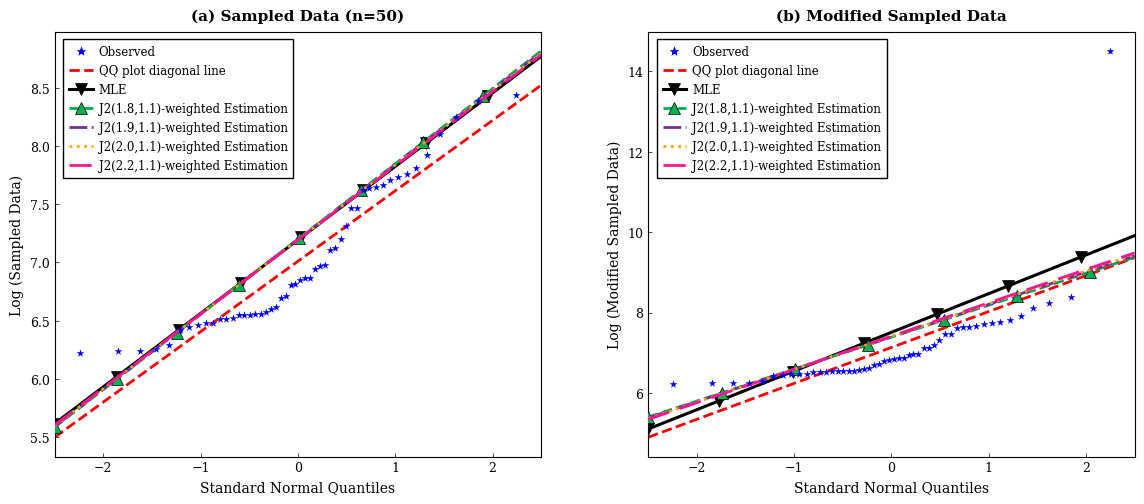


⏱️ Q-Q figure block runtime: 426.65 s


In [ ]:
# ---------- Matplotlib ----------
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 10,
    'axes.labelsize': 10,
    'axes.titlesize': 11,
    'legend.fontsize': 9,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'figure.dpi': 100,
    'savefig.dpi': 300,
    'axes.linewidth': 0.8,
    'lines.linewidth': 1.5,
    'lines.markersize': 6,
    'axes.grid': False,
})

# ---------- Globals ----------
θ  = 500.0
ln2 = np.log(2.0)

# ==============================================================
# 1) ETLL QUANTILE FUNCTION
# ==============================================================
def etll_ppf(u, alpha, beta, theta):
    u = np.clip(np.asarray(u, float), 1e-12, 1-1e-12)
    if abs(beta) < 1e-10:
        t = np.expm1((1.0 - u) * ln2)
    else:
        two_b = np.exp(beta * ln2)
        base  = np.maximum(two_b - (two_b - 1.0) * u, 1e-300)
        t     = np.expm1(np.log(base)/beta)
    return theta * np.power(np.maximum(t, 1e-300), -1.0/alpha)

# ==============================================================
# 2) DESIGN B MODELS (same set on both panels)
# ==============================================================
from collections import OrderedDict
from scipy.stats import norm

_models_designB_pub = [
    ("MLE",          lambda z: fit_mle_etll(z, θ)),
    ("J2(1.8,1.1)",  make_safe_L_designB_factory(1.0, 1.0, 1.8, 1.1)),
    ("J2(1.9,1.1)",  make_safe_L_designB_factory(1.0, 1.0, 1.9, 1.1)),
    ("J2(2.0,1.1)",  make_safe_L_designB_factory(1.0, 1.0, 2.0, 1.1)),
    ("J2(2.2,1.1)",  make_safe_L_designB_factory(1.0, 1.0, 2.2, 1.1)),
]
models_designB_pub = list(OrderedDict((k, v) for k, v in _models_designB_pub).items())

# Updated style map to match the reference image
STYLE_MAP = {
    "MLE":         dict(color="black",   linestyle="-",      linewidth=2.2,
                       marker="v", markersize=8, markevery=0.12,
                       markeredgewidth=0.5, markeredgecolor='black',
                       label="MLE"),
    "J2(1.8,1.1)": dict(color="#00B050", linestyle="--",     linewidth=2.0,
                       marker="^", markersize=8, markevery=0.12,
                       markeredgewidth=0.5, markeredgecolor='black',
                       label="J2(1.8,1.1)-weighted Estimation"),   # bright green with triangles
    "J2(1.9,1.1)": dict(color="#7030A0", linestyle="-.",     linewidth=2.0,
                       marker=None,
                       label="J2(1.9,1.1)-weighted Estimation"),   # purple dash-dot
    "J2(2.0,1.1)": dict(color="#FFA500", linestyle=":",      linewidth=2.0,
                       marker=None,
                       label="J2(2.0,1.1)-weighted Estimation"),   # orange dotted
    "J2(2.2,1.1)": dict(color="#FF1493", linestyle=(0,(8,4)), linewidth=2.0,
                       marker=None,
                       label="J2(2.2,1.1)-weighted Estimation"),   # pink loose dashed
}

# ==============================================================
# 3) Helpers for straight proxy lines + positions
# ==============================================================
def blom_positions(n: int):
    i = np.arange(1, n+1)
    return (i - 0.375) / (n + 0.25)

def model_proxy_line(alpha, beta, theta, z_min=-2.5, z_max=2.5, m=400):
    """Least-squares straight line A + B z approximating log q_model(p) over [z_min,z_max]."""
    z_grid = np.linspace(z_min, z_max, m)
    p_grid = norm.cdf(z_grid)
    y_grid = np.log(etll_ppf(p_grid, alpha, beta, theta))
    B, A = np.polyfit(z_grid, y_grid, 1)   # slope, intercept
    return A, B

# ==============================================================
# 4) Publication-style QQ panel (straight model lines with markers)
# ==============================================================
def qq_panel_publication(ax, x, panel_title=None, y_label="Log (Data)"):
    x = np.sort(np.asarray(x, float))
    n = x.size
    u = blom_positions(n)
    z = norm.ppf(u)
    y_obs = np.log(x)

    # Observed points (larger blue stars)
    ax.scatter(z, y_obs, s=35, color='blue', marker='*', zorder=5, linewidth=0, label='Observed')

    # QQ diagonal (RED dashed, thicker to match reference)
    B_data, A_data = np.polyfit(z, y_obs, 1)
    z_line = np.linspace(-2.5, 2.5, 220)
    ax.plot(z_line, A_data + B_data*z_line, '--', color='red', linewidth=2.0,
            zorder=2, label='QQ plot diagonal line')

    # Model straight proxy lines
    legend_handles, legend_labels = [], []
    for name, fit_fun in models_designB_pub:
        a_hat, b_hat = fit_fun(x)
        if not (np.isfinite(a_hat) and np.isfinite(b_hat)):
            continue
        st = STYLE_MAP[name]
        A_m, B_m = model_proxy_line(a_hat, b_hat, θ, z_line.min(), z_line.max())

        # Build line kwargs
        line_kwargs = {
            'color': st['color'],
            'linestyle': st['linestyle'],
            'linewidth': st['linewidth'],
            'zorder': 3
        }

        # Add marker properties if specified
        if st.get('marker') is not None:
            line_kwargs.update({
                'marker': st['marker'],
                'markersize': st.get('markersize', 8),
                'markevery': st.get('markevery', 0.12),
                'markeredgewidth': st.get('markeredgewidth', 0.5),
                'markeredgecolor': st.get('markeredgecolor', 'black'),
                'markerfacecolor': st['color']
            })

        line = ax.plot(z_line, A_m + B_m*z_line, **line_kwargs)[0]

        legend_handles.append(line)
        legend_labels.append(st['label'])

    # Cosmetics
    if panel_title:
        ax.set_title(panel_title, fontsize=11, fontweight='bold', pad=8)
    ax.set_xlabel("Standard Normal Quantiles", fontsize=10)
    ax.set_ylabel(y_label, fontsize=10)
    ax.set_facecolor('white')
    ax.tick_params(direction='in', length=3, width=0.5)
    ax.set_axisbelow(True)
    ax.set_xlim(z_line.min(), z_line.max())
    for sp in ax.spines.values():
        sp.set_edgecolor('black'); sp.set_linewidth(0.8)

    # Legend
    obs_handle  = plt.Line2D([0], [0], marker='*', color='w', markerfacecolor='blue',
                             markersize=10, linestyle='', label='Observed')
    diag_handle = plt.Line2D([0], [0], color='red', linewidth=2.0,
                             linestyle='--', label='QQ plot diagonal line')
    ax.legend([obs_handle, diag_handle] + legend_handles,
              ['Observed', 'QQ plot diagonal line'] + legend_labels,
              loc='upper left', bbox_to_anchor=(0.01, 0.99), fontsize=8.5,
              frameon=True, fancybox=False, framealpha=1.0, edgecolor='black',
              borderpad=0.5, columnspacing=1.0, handletextpad=0.5, borderaxespad=0.3)

# ==============================================================
# 5) Build the two-panel figure (x_sampled / x_mod_sampled already defined)
# ==============================================================
t0 = time.perf_counter()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.patch.set_facecolor('white')
plt.subplots_adjust(left=0.08, right=0.98, top=0.95, bottom=0.1, wspace=0.22)

qq_panel_publication(axes[0], x_sampled,     "(a) Sampled Data (n=50)",   "Log (Sampled Data)")
qq_panel_publication(axes[1], x_mod_sampled, "(b) Modified Sampled Data", "Log (Modified Sampled Data)")

for fmt, dpi in [('pdf', None), ('png', 300),('eps', 300)]:
    plt.savefig(f'fig_designB_qq_publication.{fmt}', format=fmt, dpi=dpi,
                bbox_inches='tight', facecolor='white', edgecolor='white')
plt.show()

print(f"\n⏱️ Q-Q figure block runtime: {time.perf_counter() - t0:.2f} s")